In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.interpolate import interp1d
from scipy.special import spherical_jn
from tqdm import tqdm

import mu2

from interaction import LocalSystem, potential
import constants as const
import utility
import bind

plt.style.use('science')
gr = 4/3
h = 3

In [2]:
const.BETA4

32.70989286766126

In [3]:
def alpha(r):
    return 9/2 - 2/3*np.exp(-2*r) * (r**5 + 9/2*r**4 + 9*r**3 + 27/2*r**2 + 27/2*r + 27/4)


def mm_potential(r):
    return -1/2 * alpha(r) / r**4

In [4]:
class ConvergedResult:
    def __init__(self, f, n, a0):
        self.f = f
        self.n = n
        self.a0 = a0

In [5]:
results = []

In [7]:
max_rel_diff = 1e-6
R_mm = 1.5
r_mesh = utility.log_mesh(0, 10*const.BETA4, 3000)

# Compute the Mott-Massey results
for f in np.arange(10, 51, 10):
    qmax = f*2/R_mm
    n = 440
    converged = False
    x0 = 1
    
    while not converged:        
        qmesh = utility.log_mesh(0, qmax, n)
        mm = LocalSystem(1.5, qmesh=(*qmesh, qmax), rmesh=r_mesh)
        vtilde_mm = utility.ft_matrix_gen(mm_potential, 0, 0, mm.q, mm.r_nodes, mm.r_weights)

        kcd_0_mm = mu2.cc.cscatter.kcotdelta_py(0, vtilde_mm, mm.q, mm.wq, mm.q_max, 0, 2*const.MU)
        x1 = -1/kcd_0_mm
        
        rel_diff = np.abs((x1-x0)/x0)
        converged = rel_diff < max_rel_diff
        x0 = x1
        print(f, n, rel_diff)
        
        if converged:
            print(f, n, x1)
            results.append(ConvergedResult(f, n, x1))
        
        n += 20

10 440 62.02046672736771
10 460 2.600513025951308e-06
10 480 2.584520404773068e-06
10 500 1.734433196545631e-06
10 520 5.136129038535004e-07
10 520 -61.02001315856125
20 440 62.065039640993334
20 460 6.697449172535354e-06
20 480 6.816701577530607e-06
20 500 1.6485134167458984e-06
20 520 3.6993496821764284e-06
20 540 2.916046792196254e-06
20 560 1.648070432775278e-06
20 580 7.912759406365627e-07
20 580 -61.06356081832989
30 440 62.066190542806574
30 460 2.124643393634786e-06
30 480 1.2602242201381506e-05
30 500 5.946101721965316e-06
30 520 3.7367433655797515e-06
30 540 3.3662290973169483e-06
30 560 3.260584854183939e-06
30 580 2.3794211747544416e-06
30 600 2.4932609954093346e-06
30 620 6.885665435792237e-07
30 620 -61.063955688339654
40 440 62.06763006698661
40 460 1.3956905098254293e-05
40 480 1.5455675089367536e-05
40 500 2.2775795675243058e-07
40 500 -61.06582001536394
50 440 62.068315125662195
50 460 1.3983480074233679e-05
50 480 9.404591208120778e-06
50 500 9.863960431133688e-06
50

In [8]:
KCD_0_MM = kcd_0_mm

In [9]:
Rs = const.BETA4/np.linspace(20, 80, 100)

In [10]:
Ri = Rs[0]
f = 20
qmax = f*2/Ri
nq = 520
qmesh = utility.log_mesh(0, qmax, nq)
ls = LocalSystem(Ri, qmesh=(*qmesh, qmax), rmesh=r_mesh)

In [11]:
def kcd0(g, ls):
    return mu2.cc.cscatter.kcotdelta_py(
        0, ls.v_tilde + ls.counterterm.gen(g, 0), ls.q, ls.wq, qmax, 0, 2*const.MU
    )

In [12]:
guess = -0.687
-1/kcd0(guess, ls), ls.bound_state_spectrum(guess, 0).size

(-60.564807925074696, 14)

In [13]:
NUM_STATES = 14

In [14]:
def froot(g, ls, qmax):
    spectrum = ls.bound_state_spectrum(g, 0)
    assert spectrum.size == NUM_STATES, f'There are {spectrum.size} bounds states.'
    return (KCD_0_MM - mu2.cc.cscatter.kcotdelta_py(
        0, ls.v_tilde + ls.counterterm.gen(g, 0), ls.q, ls.wq, qmax, 0, 2*const.MU)) / KCD_0_MM

In [15]:
froot(guess, ls, qmax)

-0.00824194371122167

In [16]:
class Data:
    def __init__(self, ls, g_lo, qmax):
        self.a0 = -1/mu2.cc.cscatter.kcotdelta_py(
            0, ls.v_tilde + ls.counterterm.gen(g_lo, 0), ls.q, ls.wq, qmax, 0, 2*const.MU)
        evals, evecs = bind.bound_states(ls.v_tilde, ls.counterterm.gen(g_lo, 0), 1, ls.q, ls.wq)
        self.lo_evals = np.copy(evals)
        self.lo_evecs = np.copy(evecs)
        self.R = ls.r_c
        self.g_lo = g_lo

In [17]:
glos = np.zeros(Rs.size)
data = []

for (i, Ri) in enumerate(Rs):
    qmax = f*2/Ri
    qmesh = utility.log_mesh(0, qmax, nq)
    ls = LocalSystem(Ri, qmesh=(*qmesh, qmax), rmesh=r_mesh)
    result = optimize.fsolve(froot, guess, args=(ls, qmax), xtol=1e-12)
    glo = result[0]
    
    glos[i] = glo
    data.append(Data(ls, glo, qmax))
    
    if i < 5:
        guess = glo
    else:
        curve = interp1d(Rs[i-5:i], glos[i-5:i], kind='cubic', fill_value='extrapolate')
        try:
            guess = curve(Rs[i+1])
        except:
            break
    
    print(f'i = {i}  R = {Ri:.4e}  g_LO = {glo:.4e}')

i = 0  R = 1.6355e+00  g_LO = -6.8714e-01
i = 1  R = 1.5874e+00  g_LO = -7.0544e-01
i = 2  R = 1.5420e+00  g_LO = -7.2205e-01
i = 3  R = 1.4992e+00  g_LO = -7.3705e-01
i = 4  R = 1.4587e+00  g_LO = -7.5057e-01
i = 5  R = 1.4203e+00  g_LO = -7.6258e-01
i = 6  R = 1.3839e+00  g_LO = -7.7297e-01
i = 7  R = 1.3493e+00  g_LO = -7.8156e-01
i = 8  R = 1.3164e+00  g_LO = -7.8823e-01
i = 9  R = 1.2850e+00  g_LO = -7.9292e-01
i = 10  R = 1.2551e+00  g_LO = -7.9563e-01
i = 11  R = 1.2266e+00  g_LO = -7.9635e-01
i = 12  R = 1.1994e+00  g_LO = -7.9503e-01
i = 13  R = 1.1733e+00  g_LO = -7.9163e-01
i = 14  R = 1.1483e+00  g_LO = -7.8609e-01
i = 15  R = 1.1244e+00  g_LO = -7.7840e-01
i = 16  R = 1.1015e+00  g_LO = -7.6853e-01
i = 17  R = 1.0794e+00  g_LO = -7.5647e-01
i = 18  R = 1.0583e+00  g_LO = -7.4223e-01
i = 19  R = 1.0379e+00  g_LO = -7.2580e-01
i = 20  R = 1.0183e+00  g_LO = -7.0720e-01
i = 21  R = 9.9947e-01  g_LO = -6.8643e-01
i = 22  R = 9.8130e-01  g_LO = -6.6355e-01
i = 23  R = 9.6377e-0

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


i = 42  R = 7.1962e-01  g_LO = 1.0649e-01
i = 43  R = 7.1015e-01  g_LO = 1.8750e-01
i = 44  R = 7.0093e-01  g_LO = 2.8616e-01
i = 45  R = 6.9194e-01  g_LO = 4.0421e-01
i = 46  R = 6.8318e-01  g_LO = 5.4341e-01
i = 47  R = 6.7464e-01  g_LO = 7.0584e-01
i = 48  R = 6.6631e-01  g_LO = 8.9411e-01
i = 49  R = 6.5819e-01  g_LO = 1.1114e+00
i = 50  R = 6.5026e-01  g_LO = 1.3614e+00
i = 51  R = 6.4252e-01  g_LO = 1.6488e+00
i = 52  R = 6.3496e-01  g_LO = 1.9790e+00
i = 53  R = 6.2757e-01  g_LO = 2.3585e+00
i = 54  R = 6.2036e-01  g_LO = 2.7952e+00
i = 55  R = 6.1331e-01  g_LO = 3.2984e+00
i = 56  R = 6.0642e-01  g_LO = 3.8796e+00
i = 57  R = 5.9968e-01  g_LO = 4.5521e+00
i = 58  R = 5.9309e-01  g_LO = 5.3323e+00
i = 59  R = 5.8664e-01  g_LO = 6.2400e+00
i = 60  R = 5.8034e-01  g_LO = 7.2989e+00
i = 61  R = 5.7416e-01  g_LO = 8.5365e+00
i = 62  R = 5.6812e-01  g_LO = 9.9899e+00
i = 63  R = 5.6220e-01  g_LO = 1.1700e+01
i = 64  R = 5.5641e-01  g_LO = 1.3717e+01
i = 65  R = 5.5073e-01  g_LO = 1.6

AssertionError: There are 15 bounds states.

In [18]:
len(data)

98

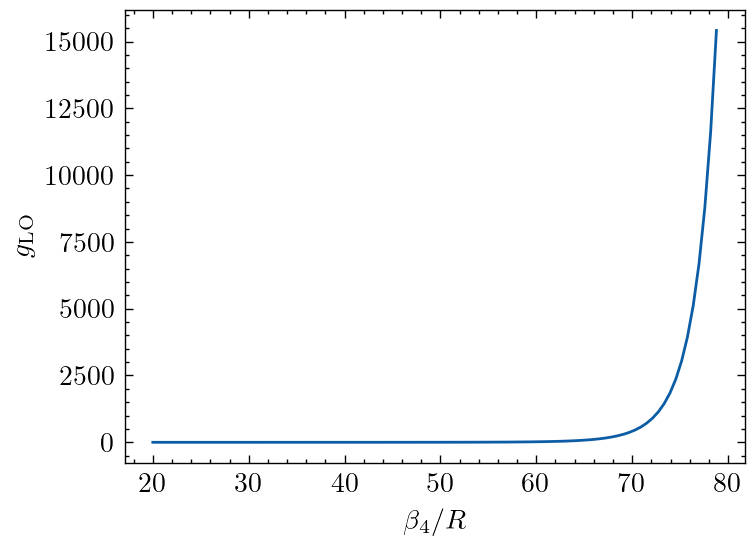

In [19]:
fig, ax = plt.subplots(figsize=(gr*h, h), dpi=200)
fig.patch.set_facecolor('white')

ax.plot(const.BETA4/Rs[:i], glos[:i])

# ax.set_ylim([-1, 1])
ax.set_xlabel(r'$\beta_4/R$')
ax.set_ylabel(r'$g_{\rm LO}$');

In [20]:
lo_specs = np.array([d.lo_evals for d in data])

In [21]:
-1/KCD_0_MM - np.array([d.a0 for d in data])

array([ 9.23705556e-14,  3.26849658e-13, -1.52766688e-12, -3.90798505e-13,
        3.90798505e-13, -1.12265752e-12,  5.82645043e-13,  8.52651283e-13,
        9.02389274e-13,  8.17124146e-13, -7.10542736e-13, -1.42108547e-13,
       -3.90798505e-13, -6.32383035e-13, -1.95399252e-12,  6.89226454e-13,
        6.39488462e-14, -1.27897692e-13, -2.84217094e-13, -2.84217094e-14,
       -2.84217094e-14,  2.84217094e-13,  2.48689958e-13,  4.90274488e-13,
       -4.40536496e-13,  1.42108547e-13,  1.37134748e-12, -1.27897692e-13,
        1.06581410e-13,  4.26325641e-14, -9.23705556e-14, -6.39488462e-14,
        2.20268248e-13, -6.11066753e-13, -1.56319402e-13, -6.39488462e-14,
        1.27897692e-13, -6.75015599e-13, -2.06057393e-13,  3.62376795e-13,
       -3.55271368e-14,  4.26325641e-13, -1.13686838e-13, -8.52651283e-13,
        9.80548975e-13,  4.40536496e-13,  4.76063633e-13, -3.90798505e-13,
        7.74491582e-13, -9.94759830e-13, -4.68958206e-13, -9.23705556e-14,
       -1.98241423e-12, -

In [22]:
mm_evals, mm_evecs = bind.bound_states(vtilde_mm, 0, 0, mm.q, mm.wq)
mm_evals

array([-0.06476099, -0.04422774, -0.02740748, -0.01466226, -0.00611664,
       -0.00156343, -0.00012025])

In [23]:
j = i

In [24]:
lo_specs[-1, 7] / mm_evals[0]

3.7343753605697194

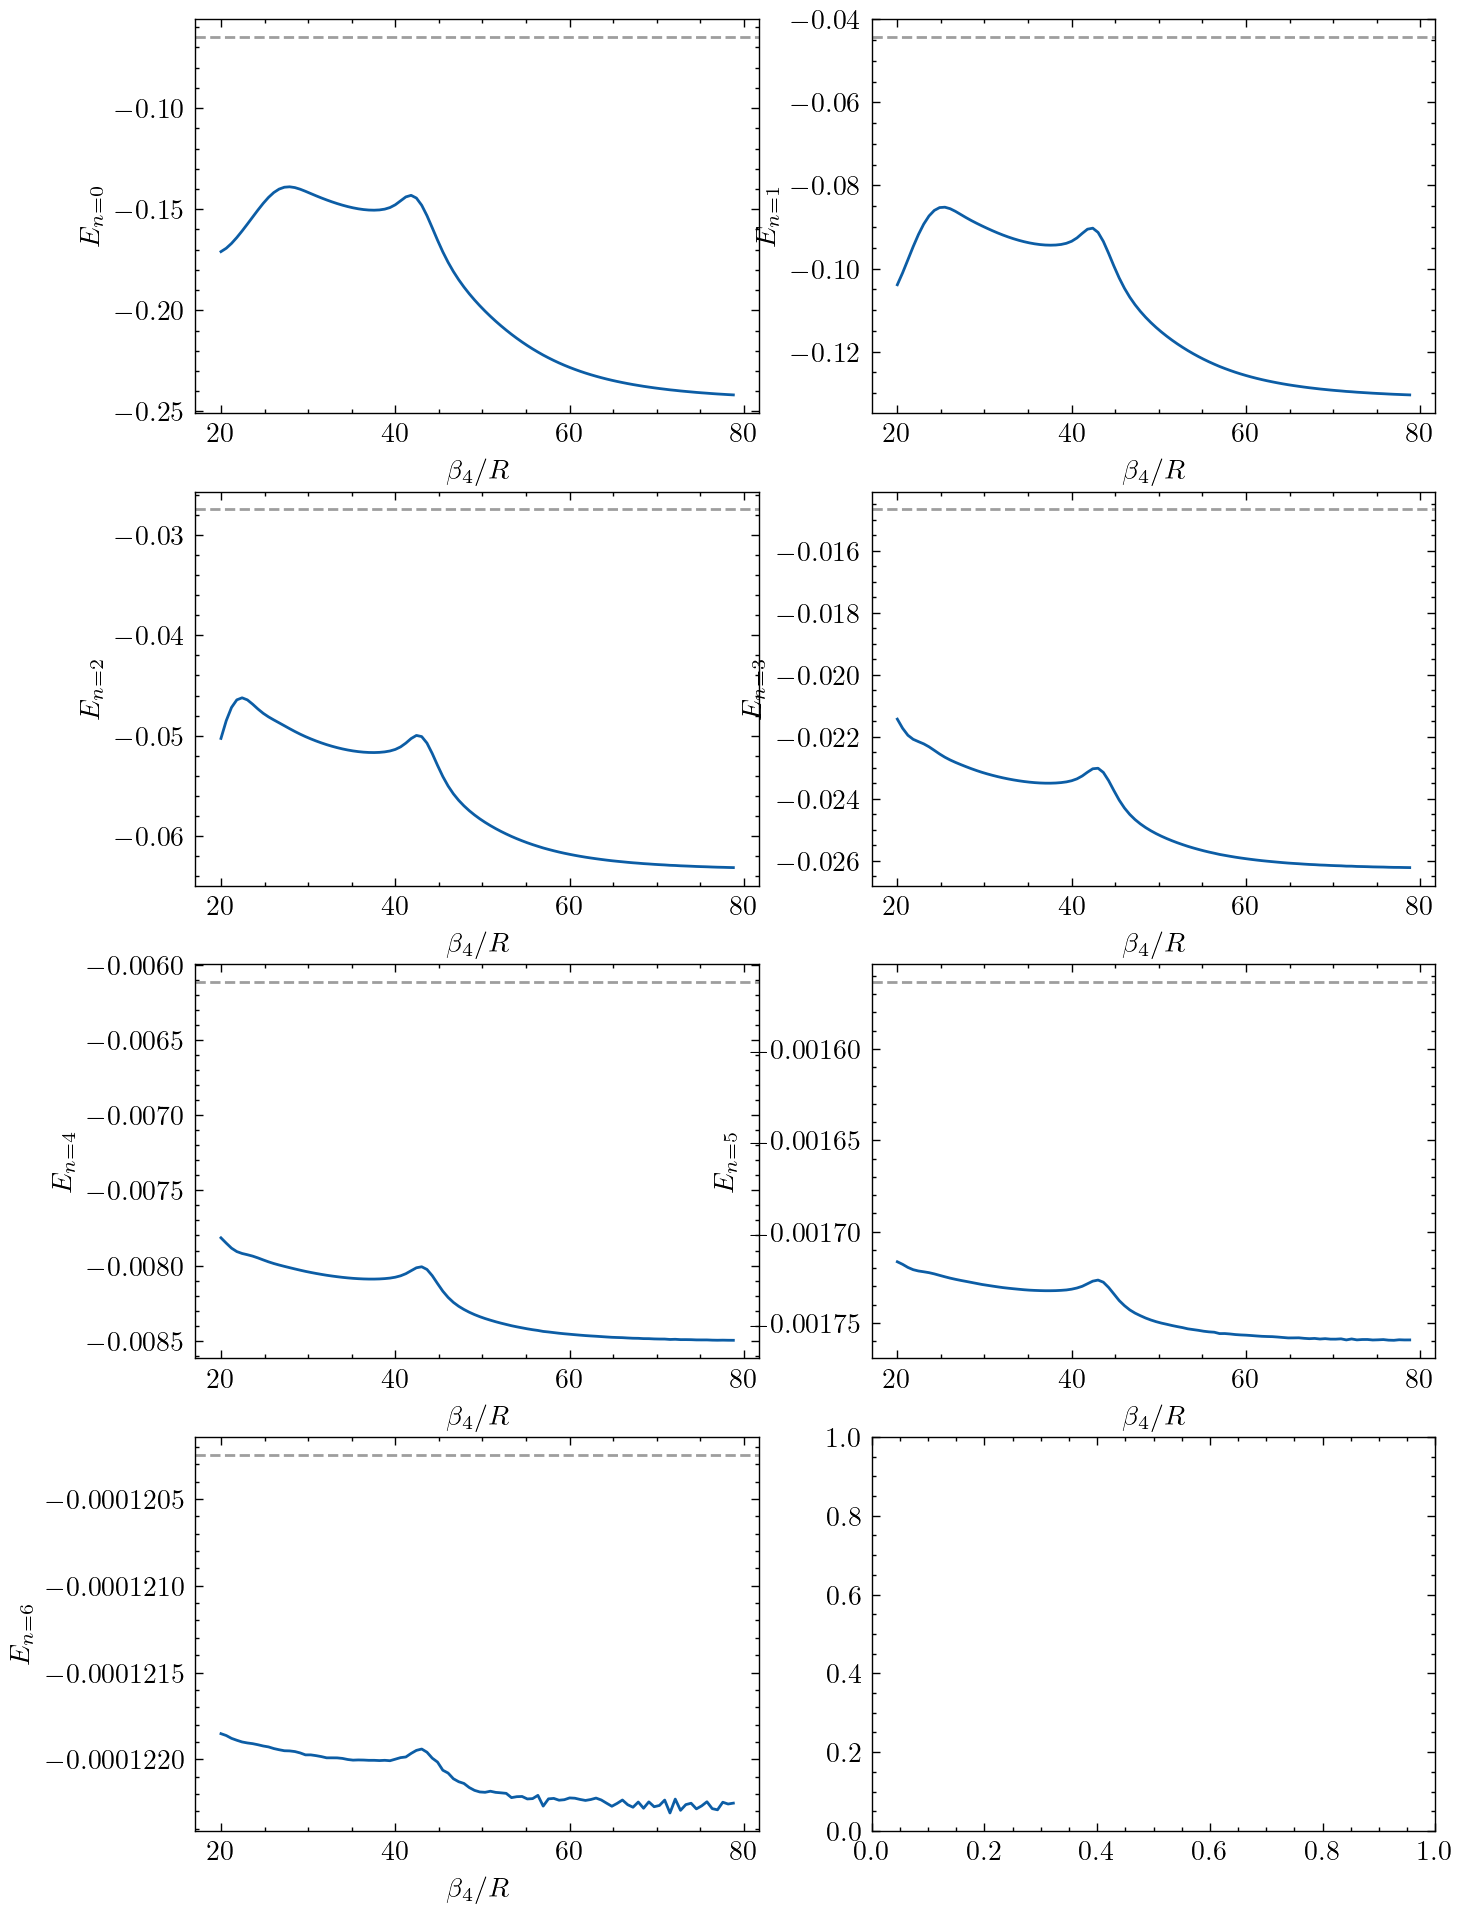

In [25]:
fig, ax = plt.subplots(4, 2, figsize=(2*gr*h, 4*h), dpi=200)
fig.patch.set_facecolor('white')

for i in range(7):
    ax[i//2, i%2].plot(const.BETA4/Rs[:j], lo_specs[:, i+7])
    ax[i//2, i%2].axhline(mm_evals[i], linestyle='--', color='C6')
    ax[i//2, i%2].set_xlabel(r'$\beta_4/R$')
    ax[i//2, i%2].set_ylabel(r'$E_{n=%d}$' % (i));

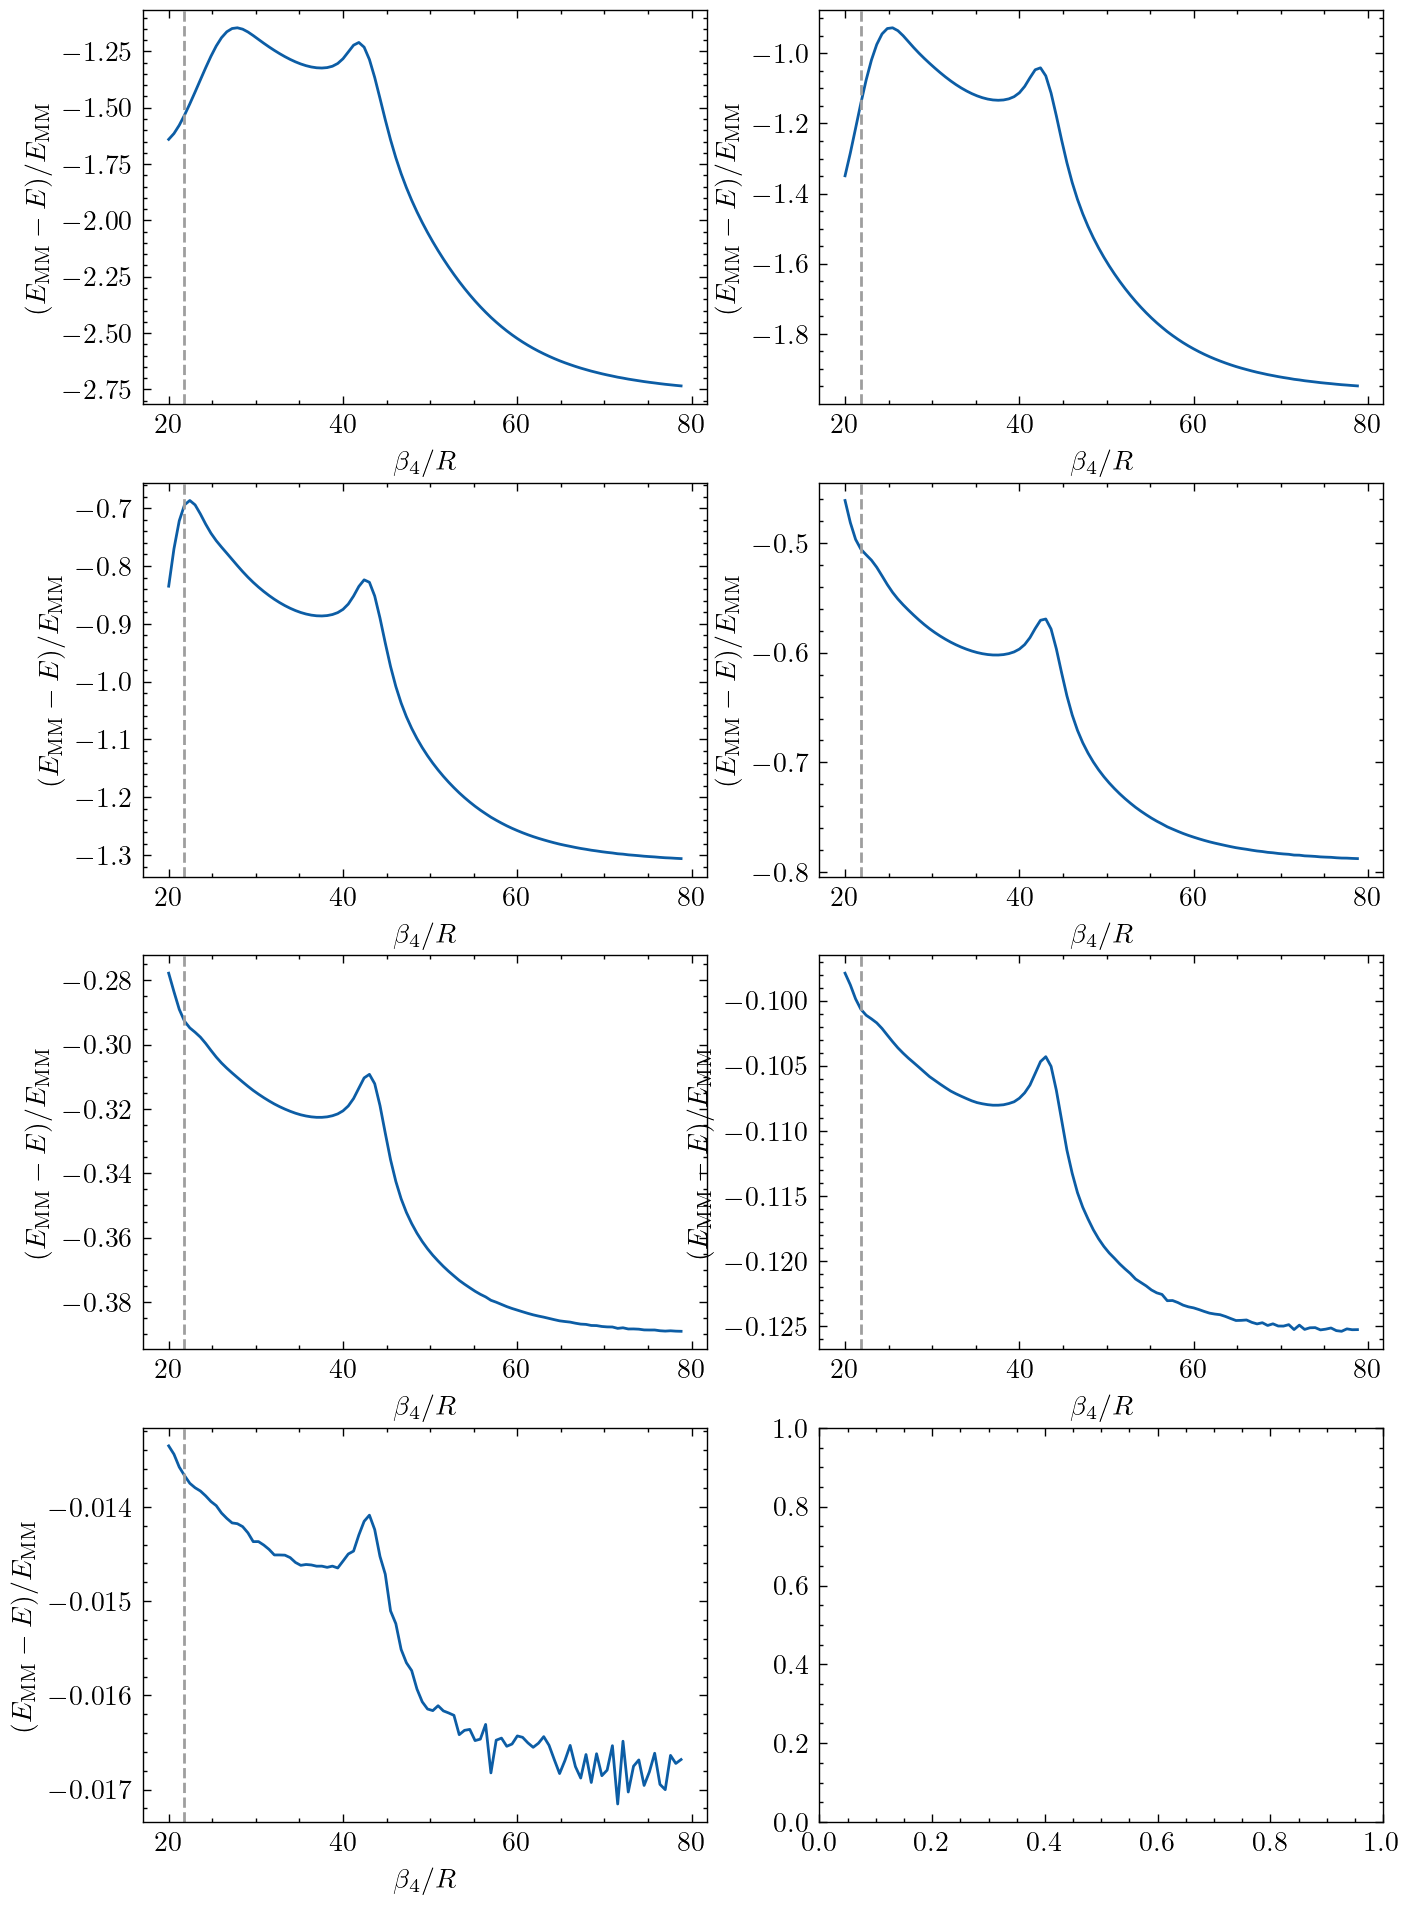

In [26]:
fig, ax = plt.subplots(4, 2, figsize=(2*gr*h, 4*h), dpi=200)
fig.patch.set_facecolor('white')

for i in range(7):
    ax[i//2, i%2].plot(const.BETA4/Rs[:j], (mm_evals[i] - lo_specs[:, i+7])/mm_evals[i])
    ax[i//2, i%2].set_xlabel(r'$\beta_4/R$')
    ax[i//2, i%2].set_ylabel(r'$(E_{\rm MM}-E)/E_{\rm MM}$')
    ax[i//2, i%2].axvline(const.BETA4/1.5, linestyle='--', color='C6')

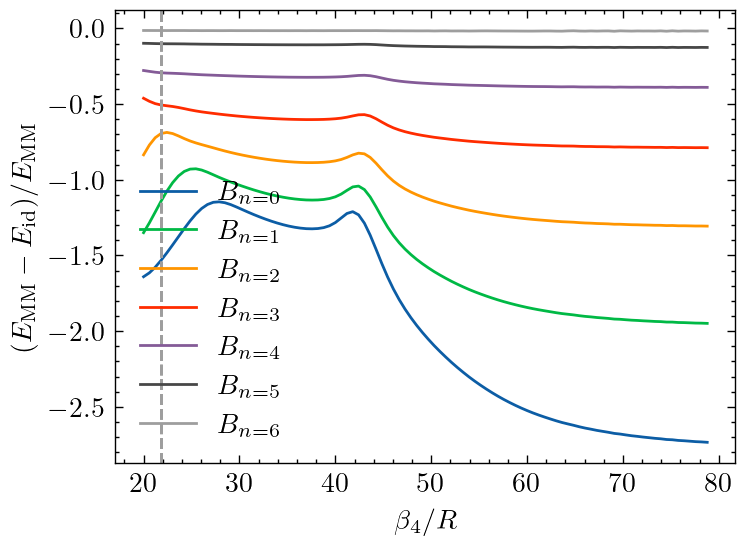

In [133]:
fig, ax = plt.subplots(figsize=(gr*h, h), dpi=200)
fig.patch.set_facecolor('white')

for i in range(7):
    ax.plot(const.BETA4/Rs[:j], (mm_evals[i] - lo_specs[:, i+7])/mm_evals[i], label='$B_{n=%d}$' % (i))
    ax.set_xlabel(r'$\beta_4/R$')
    ax.set_ylabel(r'$(E_{\rm MM}-E_{\rm id})/E_{\rm MM}$')
    ax.axvline(const.BETA4/1.5, linestyle='--', color='C6')
ax.legend();

In [134]:
np.savetxt(f'rgflow_local_lo_a0_fix_hp_n_{NUM_STATES}.txt', np.vstack((Rs[:j], glos[:j])).T, header='R  g_LO')

In [135]:
lo_specs[0, 7:]

array([-1.70996543e-01, -1.03905353e-01, -5.02906391e-02, -2.14233513e-02,
       -7.81570380e-03, -1.71647411e-03, -1.21851199e-04])

In [137]:
np.savetxt(f'spectra_local_lo_a0_fix_hp_n_{NUM_STATES}.txt', np.vstack((Rs[:j], lo_specs[:, 7:].T)).T,
           header ='R  E_0  E_1  E_2  E_3  E_4  E_5  E_6 ')

In [141]:
np.sqrt((2*const.MU*np.abs(mm_evals)))

array([5.54938194, 4.58601281, 3.61012698, 2.64051362, 1.70547162,
       0.86223713, 0.23912483])